In [17]:
from fuel_model import total_fuel_consumption
import pickle
import numpy as np
from deap import base, creator, tools
import matplotlib.pyplot as plt
import random

SEED = 42  # SEED for reproducibility
random.seed(SEED)
np.random.seed(SEED)

In [19]:
# Open aggregated dataset of speed and volume
with open('datasets/df_aggregated.pkl', 'rb') as f:
    df_aggregated = pickle.load(f)  
df_aggregated

,Roadway Name,Segment Length,Volume,Borough,Speed,Fuel Consumption
0,126 STREET,0.05,252902.0,Manhattan,16.289045,4899
1,BEDFORD AVENUE,0.50,174383.0,Brooklyn,24.492842,34612
2,SANFORD AVE,0.10,306435.0,Queens,41.486279,15571
3,WHITE PLAINS ROAD,0.05,378992.0,Bronx,39.066408,9038
4,WOODROW ROAD,0.40,47317.0,Staten Island,36.618500,8946


In [ ]:
NUM_SEGMENTS = 5  # Number of road segments

# Signal timing constraints (in seconds)
MIN_GREEN, MAX_GREEN = 10, 120
MIN_YELLOW, MAX_YELLOW = 3, 8
MIN_RED, MAX_RED = 5, 60
MIN_CYCLE_TIME, MAX_CYCLE_TIME = 30, 150

# Speed limit constraints (in mph)
MIN_SPEED, MAX_SPEED = 5, 50

def init_signal_timings():
    # Initialize random light timings as integers within defined ranges
    green = random.randint(MIN_GREEN, MAX_GREEN)
    yellow = random.randint(MIN_YELLOW, MAX_YELLOW)
    red = random.randint(MIN_RED, MAX_RED)
    
    cycle_time = green + yellow + red     # Cycle time constraint
    if cycle_time < MIN_CYCLE_TIME or cycle_time > MAX_CYCLE_TIME:
        # Adjust light timings to fit within cycle constraint
        scaling_factor = min(MAX_CYCLE_TIME / cycle_time, 1)
        green = max(MIN_GREEN, int(green * scaling_factor))
        yellow = max(MIN_YELLOW, int(yellow * scaling_factor))
        red = max(MIN_RED, int(red * scaling_factor))
    return [green, yellow, red]

def init_speed_limits():
    # Initialize speed limits as integers within the min/max range for each segment
    return [random.randint(MIN_SPEED, MAX_SPEED) for _ in range(NUM_SEGMENTS)]

In [ ]:
def calculate_ttt_and_fc(signal_timings, speed_limits, data):
    """
    Calculate Total Travel Time (TTT) and Fuel Consumption (FC)
    
    Parameters:
    - signal_timings: Contains green, yellow, and red light times.
    - speed_limits: Speed limits for each road segment.
    - data (DataFrame): Traffic data.

    Returns:
    - TTT (float): Total travel time.
    - FC (float): Total fuel consumption.
    """

    # Calculate green ratio
    green_ratio = signal_timings["green_light"] / (
        signal_timings["green_light"] + signal_timings["yellow_light"] + signal_timings["red_light"]
    )
    total_ttt = 0
    total_fc = 0

    for i, row in data.iterrows():
        segment_length = row['Segment Length']
        volume = row['Volume']
        
        avg_speed = speed_limits[i % len(speed_limits)]                             # Use speed from speed limits
        effective_ttt = (segment_length / avg_speed) * volume * (1 / green_ratio)   # Total Travel Time (TTT) calculation based on green ratio
        total_ttt += effective_ttt

        fc = total_fuel_consumption(avg_speed, volume, segment_length)  # Fuel Consumption (FC) using fuel_model.py
        total_fc += fc * volume

    return int(total_ttt), int(total_fc)

In [22]:
# Custom evaluate function for MOEA
def custom_evaluate(individual, data):
    # Extract signal timings 
    signal_timings = {
        "green_light": individual[0],
        "yellow_light": individual[1],
        "red_light": individual[2]
    }
    speed_limits = individual[3:]   # Extract speed limits
    total_ttt, total_fc = calculate_ttt_and_fc(signal_timings, speed_limits, data) 
    return total_ttt, total_fc

In [ ]:
# Custom mutation function for MOEA
def custom_mutation(individual, mu, sigma):

    # Function to mutate and clamp values with proportional mutation
    def mutate_and_clamp(value, min_value, max_value, mu, sigma):
        # Calculate mutation as a proportion of the current value
        mutation_step = value * np.random.normal(mu, sigma)  # Proportional to value
        mutated_value = value + mutation_step
        return int(max(min_value, min(mutated_value, max_value)))

    # Mutate green, yellow, and red light timings
    green = mutate_and_clamp(individual[0], MIN_GREEN, MAX_GREEN, mu, sigma)
    yellow = mutate_and_clamp(individual[1], MIN_YELLOW, MAX_YELLOW, mu, sigma)
    red = mutate_and_clamp(individual[2], MIN_RED, MAX_RED, mu, sigma)

    # Enforce cycle time constraint
    cycle_time = green + yellow + red
    if cycle_time < MIN_CYCLE_TIME or cycle_time > MAX_CYCLE_TIME:
        scaling_factor = MAX_CYCLE_TIME / cycle_time if cycle_time > MAX_CYCLE_TIME else MIN_CYCLE_TIME / cycle_time
        green = max(MIN_GREEN, min(MAX_GREEN, int(green * scaling_factor)))
        yellow = max(MIN_YELLOW, min(MAX_YELLOW, int(yellow * scaling_factor)))
        red = max(MIN_RED, min(MAX_RED, int(red * scaling_factor)))

    # Ensure positivity and enforce final bounds
    individual[0] = int(max(MIN_GREEN, min(green, MAX_GREEN)))
    individual[1] = int(max(MIN_YELLOW, min(yellow, MAX_YELLOW)))
    individual[2] = int(max(MIN_RED, min(red, MAX_RED)))

    # Mutate speed limits for the remaining segments with proportional mutation
    for i in range(3, len(individual)):
        individual[i] = mutate_and_clamp(individual[i], MIN_SPEED, MAX_SPEED, mu, sigma)
    return (individual,)

In [24]:
# Define fitness and individual structure
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

/Users/brageramberg/opt/miniconda3/envs/inf161/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/brageramberg/opt/miniconda3/envs/inf161/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
# Create an individual with 3 signal timings and `NUM_SEGMENTS` speed limits
def create_individual():
    individual = creator.Individual(toolbox.attr_signal_timings() + toolbox.attr_speed_limits())
    return individual

def custom_mate(child1, child2):
    # Uniform crossover: Each gene has a 50% chance of being swapped
    for i in range(len(child1)):
        child1[i], child2[i] = child2[i], child1[i]

def custom_elitism(population, elite_size):
    # Select the top `elite_size` individuals based on fitness.
    sorted_population = sorted(population, key=lambda ind: ind.fitness.values)
    return sorted_population[:elite_size]

In [ ]:
# Using Deap's toolbox with keep track of all the functions
toolbox.register("attr_signal_timings", init_signal_timings)
toolbox.register("attr_speed_limits", init_speed_limits)
toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Inbuilt deap, loops create individual to create the population, use of this to allow for simple configuration loop later
toolbox.register("mutate", custom_mutation, mu=0, sigma=5) 
toolbox.register("mate", custom_mate) 
toolbox.register("evaluate", custom_evaluate, data=df_aggregated)   # Register evaluation function
toolbox.register("elitism", custom_elitism)

def evolutionary_algorithm(population, toolbox, num_generations, CX_PROB, MUT_PROB, sigma=5 ,elite_size=5, PRINT=False):
    """
    Putting everything together 
    
    Parameters:
    - population: Initial population of individuals
    - toolbox: DEAP toolbox with registered functions
    - num_generations: Number of generations to run the algorithm
    - CX_PROB: Probability of crossover between pairs of individuals
    - MUT_PROB: Probability of mutation for each individual
    - elite_size: Number of top-performing individuals to retain in each generation
    - sigma: to control mutation
    - PRINT: Boolean flag for printing the population summary
    """

    for gen in range(num_generations):
        if PRINT:
            print(f"\n--- Generation {gen + 1} ---")

        # Evaluate individuals
        invalid_ind = [ind for ind in population if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Apply elitism to select top individuals
        elite_individuals = toolbox.elitism(population, elite_size)

        # Select remaining individuals for crossover and mutation
        offspring = [ind for ind in population if ind not in elite_individuals]  # Exclude elites from offspring
        offspring = list(map(toolbox.clone, offspring))  # Clone for safe genetic modifications

        # Apply crossover to offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CX_PROB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        # Apply mutation to offspring
        for mutant in offspring:
            if random.random() < MUT_PROB:
                toolbox.mutate(mutant, sigma=sigma)
                del mutant.fitness.values

        # Re-evaluate modified offspring fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Combine elites with offspring to form the new population
        population[:] = elite_individuals + offspring

        # Optional: Print population summary for each generation
        if PRINT:
            print(f"\nPopulation Summary for Generation {gen + 1}:")
            for i, ind in enumerate(population):
                print(f"Individual {i + 1}: {ind}, Fitness: {ind.fitness.values}")
    return population


In [ ]:
# running the MOEA with a set configurations
def run_moea_experiment(toolbox, config):
    # Extract configuration parameters
    POPULATION = config['POPULATION']
    NUM_GENERATIONS = config['NUM_GENERATIONS']
    CX_PROB = config['CX_PROB']         # Crossover probability
    MUT_PROB = config['MUT_PROB']       # Mutation probability
    ELITE_SIZE = max(1, int(config['POPULATION'] * 0.1))  # Ensure at least one elite
    PRINT = False
    SIGMA = config.get('SIGMA', 5)  # Default to 5 if SIGMA is not in config, SIGMA is how much a mutation happens

    population = toolbox.population(n=POPULATION) # Initialize population

    # Run the custom elitism loop for the configured number of generations
    final_population = evolutionary_algorithm(population, toolbox, NUM_GENERATIONS, CX_PROB=CX_PROB, MUT_PROB=MUT_PROB, sigma=SIGMA, elite_size=ELITE_SIZE, PRINT=PRINT)
    return final_population

# PLOTTING PARETO FRONT

In [ ]:
# Function to extract the Pareto front from the final generation's solutions
def extract_pareto_front(final_population):
    # Use DEAP's built-in function to get the Pareto front
    pareto_front = tools.sortNondominated(final_population, len(final_population), first_front_only=True)[0]
    return pareto_front

# Function to plot Pareto fronts of different configurations
def plot_pareto_fronts(pareto_fronts, configs):
    for i, pareto_front in enumerate(pareto_fronts):
        pareto_fitness = [ind.fitness.values for ind in pareto_front]
        plt.scatter(*zip(*pareto_fitness), label=f"Config {i + 1}")
    
    plt.xlabel("Objective 1 (Total Travel Time in Seconds)")
    plt.ylabel("Objective 2 (Fuel Consumption fuel units)")
    plt.title("Pareto Fronts for Different Configurations")
    plt.legend()
    plt.show()

# Function to plot Pareto fronts in subplots
def plot_pareto_fronts_in_subplots(pareto_fronts, configs, n_rows=2, n_cols=2):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    axs = axs.flatten()  # Flatten for easy indexing

    reference_x = 20000
    reference_y = 1e10

    for i in range(len(pareto_fronts)):
        ax = axs[i // 3]  # Each subplot shows 3 Pareto fronts
        pareto_fitness = [ind.fitness.values for ind in pareto_fronts[i]]
        ax.scatter(*zip(*pareto_fitness), label=f"Config {i + 1}")

        # Plot reference point as a single black cross 
        if i % 3 == 0:  # Only add the reference point for every third subplot based on the total 12 configs
            ax.plot(reference_x, reference_y, 'kx', label="Reference Point")
        
        if (i + 1) % 3 == 0:
            ax.set_xlabel("Objective 1 (Total Travel Time in Seconds)")
            ax.set_ylabel("Objective 2 (Fuel Consumption in fuel units)")
            ax.set_title(f"Pareto Fronts for Configurations {i - 1} to {i + 1}")
            ax.legend()
    
    plt.tight_layout()
    plt.show()

## MOEA CONFIGURATIONS AND RESULTS

In [ ]:
# Define 12 configurations for experimentation
configs = [
    {'POPULATION': 50, 'NUM_GENERATIONS': 50, 'CX_PROB': 0.6, 'MUT_PROB': 0.3, 'SIGMA': 6},
    {'POPULATION': 50, 'NUM_GENERATIONS': 50, 'CX_PROB': 0.7, 'MUT_PROB': 0.2, 'SIGMA': 4},
    {'POPULATION': 50, 'NUM_GENERATIONS': 50, 'CX_PROB': 0.8, 'MUT_PROB': 0.1, 'SIGMA': 2},

    {'POPULATION': 100, 'NUM_GENERATIONS': 100, 'CX_PROB': 0.6, 'MUT_PROB': 0.3, 'SIGMA': 6},
    {'POPULATION': 100, 'NUM_GENERATIONS': 100, 'CX_PROB': 0.7, 'MUT_PROB': 0.2, 'SIGMA': 4},
    {'POPULATION': 100, 'NUM_GENERATIONS': 100, 'CX_PROB': 0.8, 'MUT_PROB': 0.1, 'SIGMA': 2},

    {'POPULATION': 200, 'NUM_GENERATIONS': 200, 'CX_PROB': 0.6, 'MUT_PROB': 0.3, 'SIGMA': 6},
    {'POPULATION': 200, 'NUM_GENERATIONS': 200, 'CX_PROB': 0.7, 'MUT_PROB': 0.2, 'SIGMA': 4},
    {'POPULATION': 200, 'NUM_GENERATIONS': 200, 'CX_PROB': 0.8, 'MUT_PROB': 0.1, 'SIGMA': 2},

    {'POPULATION': 100, 'NUM_GENERATIONS': 200, 'CX_PROB': 0.9, 'MUT_PROB': 0.1, 'SIGMA': 1},
    {'POPULATION': 300, 'NUM_GENERATIONS': 400, 'CX_PROB': 0.7, 'MUT_PROB': 0.05, 'SIGMA': 10},
    {'POPULATION': 500, 'NUM_GENERATIONS': 500, 'CX_PROB': 0.8, 'MUT_PROB': 0.05, 'SIGMA': 2},
]

# Run experiments and store Pareto fronts
pareto_fronts = []
for config_index, config in enumerate(configs):
    final_generation = run_moea_experiment(toolbox, config)
    pareto_front = extract_pareto_front(final_generation)
    pareto_fronts.append(pareto_front)
    
    # Print non-dominated solutions for this configuration
    print(f"\nNon-Dominated Solutions for Configuration {config_index + 1}: {config}")
    for i, ind in enumerate(pareto_front):
        print(f"Solution {i + 1}: {ind}, Fitness: {ind.fitness.values}")


Non-Dominated Solutions for Configuration 1: {'POPULATION': 50, 'NUM_GENERATIONS': 50, 'CX_PROB': 0.6, 'MUT_PROB': 0.3, 'SIGMA': 6}
Solution 1: [110, 6, 23, 32, 49, 40, 47, 50], Fitness: (4703.0, 16053061502.0)
Solution 2: [120, 8, 21, 50, 50, 50, 23, 50], Fitness: (4733.0, 15996296089.0)
Solution 3: [79, 8, 31, 46, 50, 50, 23, 50], Fitness: (5726.0, 15868327677.0)
Solution 4: [54, 3, 7, 17, 37, 50, 25, 50], Fitness: (5747.0, 13107768323.0)
Solution 5: [43, 3, 5, 5, 50, 5, 5, 32], Fitness: (17533.0, 8877547011.0)
Solution 6: [120, 3, 5, 17, 23, 33, 50, 20], Fitness: (7241.0, 10909499545.0)
Solution 7: [16, 5, 8, 5, 25, 5, 5, 5], Fitness: (35743.0, 4834334807.0)
Solution 8: [94, 8, 5, 50, 24, 50, 5, 39], Fitness: (9987.0, 10651603390.0)
Solution 9: [120, 3, 5, 5, 12, 50, 5, 5], Fitness: (19182.0, 7083267769.0)
Solution 10: [59, 8, 5, 5, 5, 5, 5, 5], Fitness: (41090.0, 1793095287.0)
Solution 11: [120, 8, 22, 50, 18, 5, 5, 12], Fitness: (20740.0, 5271608380.0)

Non-Dominated Solutions fo

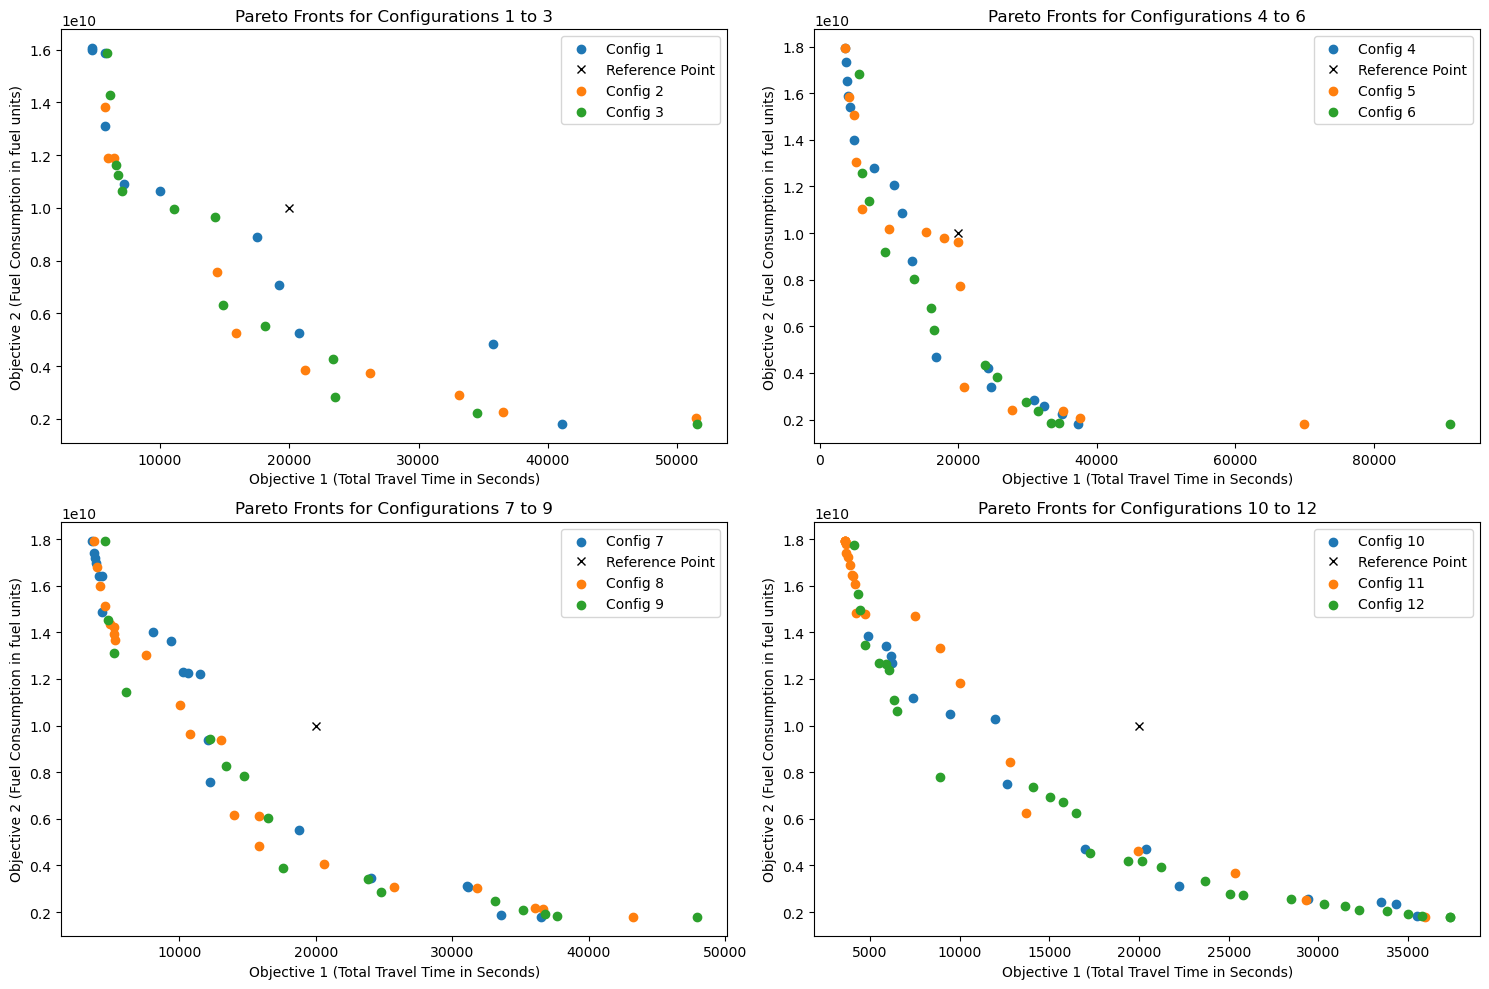

In [30]:
# Plot Pareto fronts in 4 subplots with 3 fronts each
plot_pareto_fronts_in_subplots(pareto_fronts, configs)

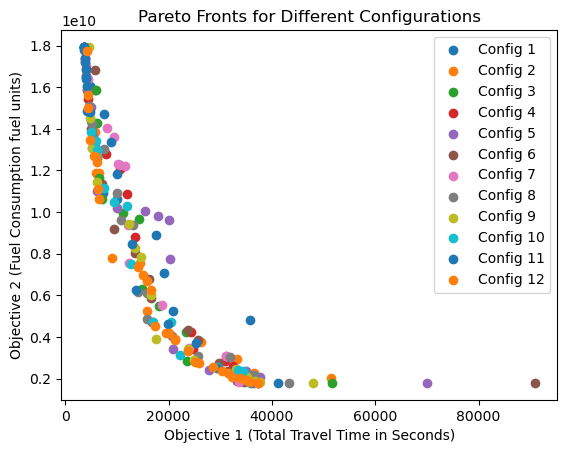

In [31]:
# Plot all results of Pareto fronts for each configuration
plot_pareto_fronts(pareto_fronts, configs)

In [ ]:
# Function to extract the global Pareto front from multiple configuration fronts
def extract_global_pareto_front(all_pareto_fronts):
    # Flatten all Pareto fronts into a single list
    combined_fronts = [ind for pareto_front in all_pareto_fronts for ind in pareto_front]
    # Get the non-dominated solutions from the combined list
    global_pareto_front = tools.sortNondominated(combined_fronts, len(combined_fronts), first_front_only=True)[0]
    return global_pareto_front

# Function to print the top N individuals based on normalized metric
def print_top_solutions(global_pareto_front, pareto_fronts, top_n=10):
    config_labels = {}

    # Assign config labels to each individual in the global Pareto front
    for config_index, pareto_front in enumerate(pareto_fronts):
        for ind in pareto_front:
            fitness_tuple = tuple(ind.fitness.values)
            if fitness_tuple in [tuple(ind.fitness.values) for ind in global_pareto_front]:
                config_labels[fitness_tuple] = config_index + 1  # Store the config number

    # Get min and max values for normalization
    min_ttt = min(ind.fitness.values[0] for ind in global_pareto_front)  # Min TTT
    max_ttt = max(ind.fitness.values[0] for ind in global_pareto_front)  # Max TTT
    min_fc = min(ind.fitness.values[1] for ind in global_pareto_front)  # Min FC
    max_fc = max(ind.fitness.values[1] for ind in global_pareto_front)  # Max FC

    # Sort for global Pareto front by a normalized metric
    def normalized_score(ind):
        normalized_ttt = (ind.fitness.values[0] - min_ttt) / (max_ttt - min_ttt) if max_ttt > min_ttt else 0
        normalized_fc = (ind.fitness.values[1] - min_fc) / (max_fc - min_fc) if max_fc > min_fc else 0
        return normalized_ttt + normalized_fc

    sorted_pareto_front = sorted(global_pareto_front, key=normalized_score)
    top_individuals = sorted_pareto_front[:top_n]  # Get the top individuals

    # Print details of the top solutions
    print(f"Top {top_n} Individuals in the Global Pareto Front (by normalized metric):")
    for ind in top_individuals:
        fitness_tuple = tuple(ind.fitness.values)
        config_label = f"Config {config_labels[fitness_tuple]}"
        genes = ind[:]  # Extract the genes (chromosome values) of the individual
        print(f"Configuration: {config_label}, Fitness: {fitness_tuple}, Genes: {genes}")

# Extract the global Pareto front from all configurations
global_pareto_front = extract_global_pareto_front(pareto_fronts)

# Print the top 10 individuals in the global Pareto front based on normalized metric
print_top_solutions(global_pareto_front, pareto_fronts, top_n=10)

Top 10 Individuals in the Global Pareto Front (by normalized metric):
Configuration: Config 12, Fitness: (8927.0, 7775318158.0), Genes: [120, 4, 5, 11, 27, 21, 17, 14]
Configuration: Config 9, Fitness: (17601.0, 3898829949.0), Genes: [120, 3, 5, 14, 13, 5, 12, 16]
Configuration: Config 8, Fitness: (15878.0, 4849739488.0), Genes: [120, 8, 5, 5, 19, 6, 11, 50]
Configuration: Config 4, Fitness: (16746.0, 4703941393.0), Genes: [120, 3, 5, 5, 17, 5, 18, 22]
Configuration: Config 11, Fitness: (13689.0, 6251083463.0), Genes: [120, 3, 5, 37, 13, 27, 5, 22]
Configuration: Config 12, Fitness: (17279.0, 4520600251.0), Genes: [120, 3, 23, 21, 10, 14, 12, 17]
Configuration: Config 8, Fitness: (14041.0, 6167413910.0), Genes: [120, 8, 8, 5, 20, 23, 5, 50]
Configuration: Config 7, Fitness: (12250.0, 7568179176.0), Genes: [120, 3, 5, 49, 28, 5, 14, 30]
Configuration: Config 10, Fitness: (12665.0, 7490133575.0), Genes: [120, 3, 5, 11, 16, 44, 5, 24]
Configuration: Config 5, Fitness: (20835.0, 3412684618

## OLD CODE
- For possible reference

In [33]:
# Repair function to ensure values are within valid bounds, this is no longer used because the negative values for individuals were fixed
def repair_individual_old(individual):
    #Debug: Check after repair
    for i, value in enumerate(individual):
        if value < 0:
            print(f"ERROR individual negative? {i}: {value}")

    # Clamp signal timings to ensure they are within valid bounds
    individual[0] = int(max(MIN_GREEN, min(individual[0], MAX_GREEN)))
    individual[1] = int(max(MIN_YELLOW, min(individual[1], MAX_YELLOW)))
    individual[2] = int(max(MIN_RED, min(individual[2], MAX_RED)))
    
    # Clamp speed limits
    for i in range(3, len(individual)):
        individual[i] = int(max(MIN_SPEED, min(individual[i], MAX_SPEED)))
    return individual

In [34]:
# Custom mutation function for MOEA
def custom_mutation_old(individual, mu, sigma, indpb):
    # print(f"\nStarting mutation for individual: {individual}")  # Debug

    green, yellow, red = individual[0], individual[1], individual[2]

    # Mutate green light timing and clamp
    if np.random.rand() < indpb:
        mutated_value = green + np.random.normal(mu, sigma)
        green = int(max(MIN_GREEN, min(mutated_value, MAX_GREEN)))
        # print(f"Traffic light mutation (green): Previous: {individual[0]}, Mutated: {green}")  # Debug

    # Mutate yellow light timing and clamp
    if np.random.rand() < indpb:
        mutated_value = yellow + np.random.normal(mu, sigma)
        yellow = int(max(MIN_YELLOW, min(mutated_value, MAX_YELLOW)))
        # print(f"Traffic light mutation (yellow): Previous: {individual[1]}, Mutated: {yellow}") # Debug

    # Mutate red light timing and clamp
    if np.random.rand() < indpb:
        mutated_value = red + np.random.normal(mu, sigma)
        red = int(max(MIN_RED, min(mutated_value, MAX_RED)))
        # print(f"Traffic light mutation (red): Previous: {individual[2]}, Mutated: {red}") # Debug

    # Enforce the cycle time constraint
    cycle_time = green + yellow + red
    if cycle_time < MIN_CYCLE_TIME or cycle_time > MAX_CYCLE_TIME:
        if cycle_time > MAX_CYCLE_TIME:
            scaling_factor = MAX_CYCLE_TIME / cycle_time
            green = max(MIN_GREEN, int(green * scaling_factor))
            yellow = max(MIN_YELLOW, int(yellow * scaling_factor))
            red = max(MIN_RED, int(red * scaling_factor))
            
        elif cycle_time < MIN_CYCLE_TIME:
            scaling_factor = MIN_CYCLE_TIME / cycle_time
            green = min(MAX_GREEN, max(MIN_GREEN, int(green * scaling_factor)))
            yellow = min(MAX_YELLOW, max(MIN_YELLOW, int(yellow * scaling_factor)))
            red = min(MAX_RED, max(MIN_RED, int(red * scaling_factor)))

    # Ensure positivity and enforce final bounds
    green = int(max(MIN_GREEN, min(green, MAX_GREEN)))
    yellow = int(max(MIN_YELLOW, min(yellow, MAX_YELLOW)))
    red = int(max(MIN_RED, min(red, MAX_RED)))

    # Apply the adjusted integer values back to the individual
    individual[0], individual[1], individual[2] = green, yellow, red

    # Mutate speed limits for the remaining segments
    for i in range(3, len(individual)):
        if np.random.rand() < indpb:
            # Apply mutation with Gaussian noise, round, and then clamp to enforce constraints
            mutated_speed = int(round(individual[i] + np.random.normal(mu, sigma)))
            
            # Ensure the mutated speed is within min and max limits
            new_speed = int(max(MIN_SPEED, min(mutated_speed, MAX_SPEED)))
            
            # Debug for negative values
            if new_speed < MIN_SPEED:
                print("Error: Speed limit became negative after mutation.")
                new_speed = MIN_SPEED  # Set to minimum allowed

            # Debugging print to verify mutation step-by-step
            # if new_speed != individual[i]:
            #     print(f"Speed limit mutation: Previous: {individual[i]}, Mutated: {new_speed}")

            # Update the individual with the clamped, integer speed limit
            individual[i] = new_speed
    return (individual,)

In [35]:

# # test run early MOEA with prints

# # Initialize population
# population = toolbox.population(n=POPULATION)

# # Ensure all individuals are repaired after initialization (if needed)
# for ind in population:
#     repair_individual(ind)

# for gen in range(NUM_GENERATIONS):
#     print(f"\n--- Generation {gen + 1} ---")

#     # Select offspring for the next generation
#     offspring = toolbox.select(population, MU)
#     offspring = list(map(toolbox.clone, offspring))

#     # Apply crossover to offspring
#     for child1, child2 in zip(offspring[::2], offspring[1::2]):
#         if random.random() < CX_PROB:
#             mate_and_repair(child1, child2, ALPHA)
#             del child1.fitness.values  # Clear fitness because offspring was modified
#             del child2.fitness.values

#     # Apply mutation to offspring
#     for mutant in offspring:
#         if random.random() < MUT_PROB:
#             custom_mutation(mutant, mu=0, sigma=5, indpb=0.2)  # Using your custom mutation
#             repair_individual(mutant)  # Ensure bounds after mutation
#             del mutant.fitness.values  # Clear fitness because mutant was modified

#     # Evaluate the offspring
#     invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
#     fitnesses = map(toolbox.evaluate, invalid_ind)
#     for ind, fit in zip(invalid_ind, fitnesses):
#         repair_individual(ind)  # Final repair before evaluation to ensure bounds
#         ind.fitness.values = fit

#     # Replace population with offspring for the next generation
#     population[:] = offspring

#     # Print summary of the current generation
#     print(f"\nPopulation Summary for Generation {gen + 1}:")
#     for i, ind in enumerate(population):
#         print(f"Individual {i + 1}: {ind}, Fitness: {ind.fitness.values}")

# # Print the final population after running the genetic algorithm
# print("\n--- Final Population ---")
# for i, ind in enumerate(population):
#     print(f"Final Individual {i + 1}: {ind}, Fitness: {ind.fitness.values}")